<a href="https://colab.research.google.com/github/flaviovdf/musica/blob/main/notebooks/lab07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-tmppp_qc
  Running command git clone -q https://github.com/flaviovdf/musica.git /tmp/pip-req-build-tmppp_qc
     |████████████████████████████████| 207 kB 6.6 MB/s 
     |████████████████████████████████| 126 kB 38.0 MB/s 
     |████████████████████████████████| 65 kB 1.0 MB/s 
  Created wheel for musica-dcc-ufmg: filename=musica_dcc_ufmg-0.1-py3-none-any.whl size=3413 sha256=7f1940108e4b1688057b8ef48970a211a1ff730f963f84ff11f6f510f6b62508
  Stored in directory: /tmp/pip-ephem-wheel-cache-7eqhw7me/wheels/94/cb/e0/72e4ee72153bf78a970722ac92a93e8a8f31c1853e32a3d1bc
Successfully built musica-dcc-ufmg


# Music Auto Tagging (Multi-Label Classification and Metric Learning Approach)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems. 

Two central methods for representation learning include deep metric learning and classification, both having the same goal of learning a representation that can generalize well across tasks.

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

## Importing Packages

In [ ]:
from μsica import μsf
from μsica import μsp

from glob import glob

import flax.linen as nn
import jax.numpy as jnp
import jax

import librosa
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import pandas as pd

In [ ]:
μsf.download('https://dcc.ufmg.br/~flaviovdf/mir/lab07/files.zip', 'files.zip',
             False)
μsf.extract('files.zip', '.')

files.zip: 300MB [00:41, 7.55MB/s]


In [ ]:
μsp.init_matplotlib()
plt.ion()

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [ ]:
df = pd.read_csv('subset_magnatune.csv', index_col=0)
df.shape

(1048, 189)

In [ ]:
df.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,sitar,chorus,female opera,male vocal,vocals,clarinet,heavy,silence,beats,men,woodwind,funky,no strings,chimes,foreign,no piano,horns,classical,female,no voices,soft rock,eerie,spacey,jazz,guitar,quiet,no beat,banjo,electric,solo,...,scary,india,woman,woman singing,rock,dance,piano solo,guitars,no drums,jazzy,singing,cello,calm,female vocals,voices,different,techno,clapping,house,monks,flute,not opera,not english,oriental,beat,upbeat,soft,noise,choir,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0/rocket_city_riot-last_of_the_pleasure_seeker...
293,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-59-88.npy
294,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-88-117.npy
303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1/ambient_teknology-phoenix-01-ambient_teknolo...


[Text(0, 0.5, 'Frequência')]

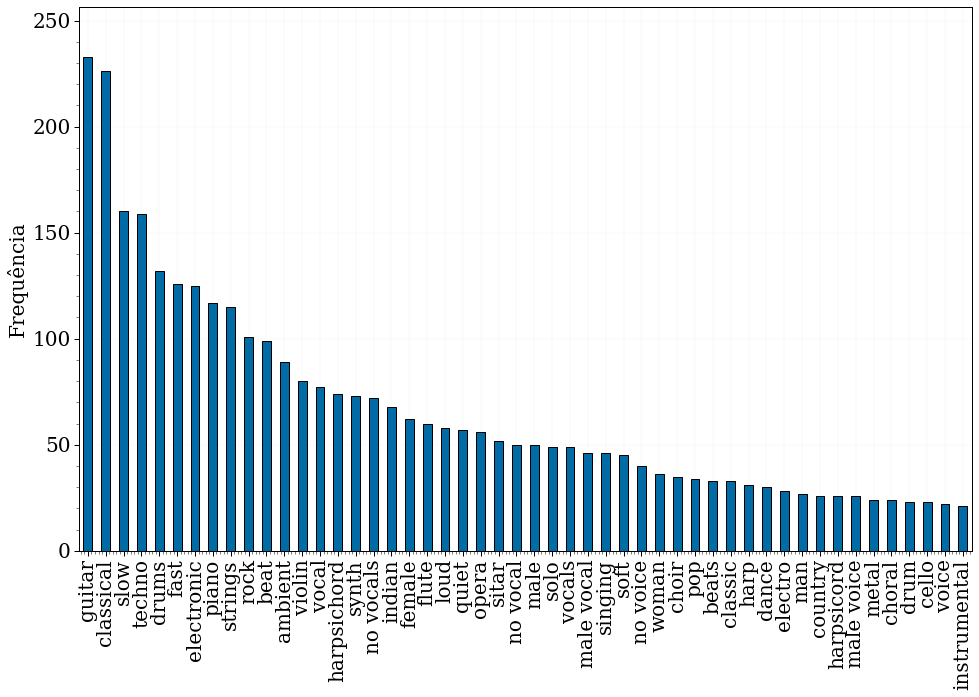

In [ ]:
_, ax = plt.subplots(1, 1)
(df.iloc[:, :-1].sum().
 sort_values(ascending=False)[:50].
 plot.bar(ax=ax, rot=90, edgecolor='k')
)
ax.set(ylabel='Frequência')

In [ ]:
top = (df.iloc[:, :-1].sum().
       sort_values(ascending=False)[:50]).index
top

Index(['guitar', 'classical', 'slow', 'techno', 'drums', 'fast', 'electronic',
       'piano', 'strings', 'rock', 'beat', 'ambient', 'violin', 'vocal',
       'harpsichord', 'synth', 'no vocals', 'indian', 'female', 'flute',
       'loud', 'quiet', 'opera', 'sitar', 'no vocal', 'male', 'solo', 'vocals',
       'male vocal', 'singing', 'soft', 'no voice', 'woman', 'choir', 'pop',
       'beats', 'classic', 'harp', 'dance', 'electro', 'man', 'country',
       'harpsicord', 'male voice', 'metal', 'choral', 'drum', 'cello', 'voice',
       'instrumental'],
      dtype='object')

In [ ]:
df = df[[c for c in top] + ['mp3_path']]
df.shape

(1048, 51)

In [ ]:
(df.sum(axis=1) == 0).any()

True

In [ ]:
df = df[df.sum(axis=1) != 0]
df = df.sample(frac=1)
df.head()

,guitar,classical,slow,techno,drums,fast,electronic,piano,strings,rock,beat,ambient,violin,vocal,harpsichord,synth,no vocals,indian,female,flute,loud,quiet,opera,sitar,no vocal,male,solo,vocals,male vocal,singing,soft,no voice,woman,choir,pop,beats,classic,harp,dance,electro,man,country,harpsicord,male voice,metal,choral,drum,cello,voice,instrumental,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54491,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0/ensemble_vermillian-stolen_jewels-17-j_m__ba...
3064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2/indidginus-as_above_so_below-01-obsidian-117...
10184,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b/lisa_debenedictis-mixter_one-02-structured_e...
39828,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c/hands_upon_black_earth-hands_upon_black_eart...
21769,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a/liquid_zen-magic_midsummer-05-come_to_that-8...


In [ ]:
train_df = df[:768]
val_df = df[768:896]
test_df = df[896:896+128]

print(train_df.shape, val_df.shape, test_df.shape)

(768, 51) (128, 51) (128, 51)


# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [ ]:
def to_mel_spectrum(wave, sr=16000, n_fft=516, n_mels=96, secs=6):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [ ]:
def load_data(file_paths):
    for fpath in file_paths:
        fpath = os.path.join('waveform', fpath)
        yield np.load(fpath)

In [ ]:
data_train = list(map(to_mel_spectrum, load_data(train_df['mp3_path'])))
X_train = jnp.array(data_train)
Y_train = jnp.array(train_df.drop('mp3_path', axis=1).values)

data_val = list(map(to_mel_spectrum, load_data(val_df['mp3_path'])))
X_val = jnp.array(data_val)
Y_val = jnp.array(val_df.drop('mp3_path', axis=1).values)

data_test = list(map(to_mel_spectrum, load_data(test_df['mp3_path'])))
X_test = jnp.array(data_test)
Y_test = jnp.array(test_df.drop('mp3_path', axis=1).values)

## Iterating in Batches

In [ ]:
batch_size = 16
X_batches = X_train.reshape((X_train.shape[0] // batch_size,
                             batch_size,
                             X_train.shape[1],
                             X_train.shape[2]))
Y_batches = Y_train.reshape((Y_train.shape[0] // batch_size,
                             batch_size,
                             Y_train.shape[1]))

In [ ]:
Xb, Yb = X_batches[0], Y_batches[0]
Xb.shape

(16, 96, 188)

In [ ]:
Yb.shape

(16, 50)

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

In [ ]:
class Baseline(nn.Module):
    @nn.compact
    def __call__(self, x):
        for _ in range(3):
            x = nn.Conv(96, kernel_size=(3, ), strides=(1, ))(x)
            x = nn.relu(x)
            x = nn.max_pool(x, window_shape=(3, ), strides=(1, ))
        x = nn.avg_pool(x, window_shape=(1, ))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(50)(x)
        x = nn.log_softmax(x)
        return x

In [ ]:
model = Baseline()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))

In [ ]:
logits = Baseline().apply(variables, Xb)
logits.shape

(16, 50)

In [ ]:
@jax.jit
def cross_entropy_loss(logits, Yb):
    return -jnp.mean(jnp.sum(Yb * logits, axis=-1))

In [ ]:
logits = Baseline().apply(variables, Xb)
cross_entropy_loss(logits, Yb)

DeviceArray(119.86165, dtype=float32)

In [ ]:
logits = Baseline().apply(variables, X_train)
cross_entropy_loss(logits, Y_train)

DeviceArray(119.756195, dtype=float32)

In [ ]:
logits = Baseline().apply(variables, X_val)
cross_entropy_loss(logits, Y_val)

DeviceArray(134.8101, dtype=float32)

In [ ]:
logits = Baseline().apply(variables, X_test)
cross_entropy_loss(logits, Y_test)

DeviceArray(117.865005, dtype=float32)

In [ ]:
@jax.jit
def train_step(Xb, Yb, state):
    def loss_fn(params):
        logits = Baseline().apply({'params': params}, Xb)
        loss = cross_entropy_loss(logits, Yb)
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [ ]:
from flax.training import train_state

model = Baseline()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))

lr = 0.0005
iter = 50

params = variables['params']
tx = optax.sgd(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=tx)
for i in range(iter):
    for Xb, Yb in zip(X_batches, Y_batches):
        state = train_step(Xb, Yb, state)
    train_loss = cross_entropy_loss(Baseline().apply({'params': state.params},
                                                     X_train),
                                    Y_train)
    val_loss = cross_entropy_loss(Baseline().apply({'params': state.params},
                                                   X_val),
                                  Y_val)
    if i % 10 == 0:
        print('Iter: {}; Train Loss {}; Val Loss = {}'.format(i, train_loss,
                                                              val_loss))

Iter: 0; Train Loss 12.441466331481934; Val Loss = 14.110729217529297
Iter: 10; Train Loss 10.97637939453125; Val Loss = 13.12862777709961
Iter: 20; Train Loss 10.06350040435791; Val Loss = 13.136550903320312
Iter: 30; Train Loss 9.261343002319336; Val Loss = 13.40893268585205
Iter: 40; Train Loss 8.553181648254395; Val Loss = 14.030738830566406


In [ ]:
def auto_tagging(id, df, X, model, params, topk):
    row = df.iloc[id].copy()
    audio_sample = [row['mp3_path']]
    row = row.drop('mp3_path')
    wave = next(load_data(audio_sample))

    X = jnp.array([X[id]])
    logit = model().apply({'params': params}, X)[0]
    idx = logit.argsort()[-topk:][::-1]

    return wave, row[idx].index

In [ ]:
import IPython.display as ipd

id = 30
wave, tags = auto_tagging(id, test_df, X_test, Baseline, state.params, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['classical', 'piano', 'strings', 'harpsichord', 'harp'], dtype='object')


### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings! 

### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size 
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...). 

* You can also use ResNet or other CNNs with skip connections. 

* Furthermore, you can augment data using digital audio effects.

### [Question 3] Improve the performance.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* Change backbone model
  - https://arxiv.org/abs/1711.02520
  - https://arxiv.org/abs/2006.00751